In [48]:
import scipy
from scipy import sparse
import numpy as np 
import sklearn 
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn import metrics

import matplotlib.pyplot as plt

import sys
import pickle

## Get pl_queries from db

In [2]:
# get data from SQL 
import pymysql
import configparser

queries={}

# print cursor function
def pc(cursor):
	for x in cursor:
		print(x)

# reads the config file
config = configparser.ConfigParser()
config.read("config.ini")

conn = pymysql.connect(
	host = config.get("Database", "mysql_ip"),
	user = config.get("Database", "mysql_user"),
	passwd = config.get("Database", "mysql_pw"))

mycursor = conn.cursor()

mycursor.execute("Use pl_queries")
mycursor.execute("SELECT * FROM Queries")
# conn.commit()

1418

In [3]:
for tup in mycursor:
    # queryId --> [variantId, queryText]
    queries[tup[0]] = [tup[2], tup[3]]

In [4]:
query_text=[queries[x][1] for x in queries]

In [5]:
len(queries)

1418

analysis for paper

In [6]:
keywords = ["group by", "natural join"]

count=0
word="natural join"
for q in query_text:
#     words=q.split(" ")
#     sels=0
#     for w in words:
#         if "select" in w.lower():
#             sels+=1
#     if sels>2:
#         count+=1     
    if "group by" in q.lower() and "having" in q.lower():
        count+=1
print(word, count)
        

natural join 157


## Get list of all questions from db

In [7]:
mycursor.execute("SELECT queryNum, COUNT(*) FROM Queries GROUP BY queryNum")

1418

In [8]:
mycursor.execute("SELECT variantID FROM Queries GROUP BY variantID")
question_ids=[]
for question in mycursor:
    question_ids.append(question[0])

In [9]:
len(queries)

1418

# Clustering 

In [ ]:
def get_ari(x, labels):
    ari = metrics.adjusted_rand_score(labels, x) 
    print("ARI index: " + str(ari))

In [10]:
q_dic={}
for key in queries:
    variant=queries[key][0]
    if variant in q_dic:
        q_dic[variant]+=1
    else:
        q_dic[variant]=1
        

In [144]:
NUM_CLUSTERS = len(q_dic)

file_keywords = "KeywordizedQueryEmbeddings.pickle"
file_raw= "RawQueryEmbeddings.pickle"
emb=pickle.load(open(file_keywords, "rb" ))

In [145]:
# given embeddings,
# return 
#   the queryNum and embeddings for associated queries 

def get_clustering_input(emb):
    data=[]
    qids=[]

    for key in emb:
        qids.append(key)
        data.append(emb[key])
    return data, qids

In [146]:
data, qids=get_clustering_input(emb)

In [147]:
## get labels (questionIds)
labels=[]

for key in qids:
    labels.append(queries[key][0])

## Kmeans 

### First, let's see if embeddings can cluster the set of ALL queries, by their questionId


In [148]:
# given data, return list of clusters 
def kmeans(data, NUM_CLUSTERS):
    km = KMeans(n_clusters=NUM_CLUSTERS)
    km.fit(data)

    clusters = km.labels_.tolist()
    clusters = np.asarray(clusters)
    
    # testing bincount 
    # can compare to q_dic to see questions distribution 
    print("Distribution of clusters: ")
    counter={}
    for i in clusters:
        if i in counter: 
            counter[i]+=1
        else:
            counter[i] = 1
    print(counter)
    
    return clusters

In [169]:
kmeans_clusters = kmeans(data, NUM_CLUSTERS)

Distribution of clusters: 
{13: 139, 2: 128, 12: 65, 18: 96, 15: 88, 0: 16, 10: 83, 7: 62, 16: 95, 9: 68, 17: 114, 5: 50, 6: 80, 3: 49, 4: 42, 11: 31, 8: 91, 1: 77, 14: 44}


In [170]:
get_ari(kmeans_clusters, labels)

ARI index: 0.3117530789611275


<BarContainer object of 19 artists>

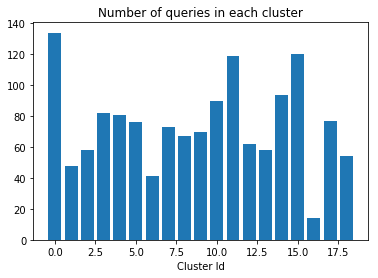

In [58]:
# bincount counts the number of occurences of each number in the array
# i.e., bincount[0] is the # of times 0 occurs 
#       bincount[1] is the # of times 1 occurs 

plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(kmeans_clusters))

### View KMeans results:
- Change "i" to the cluster number 
- All the queries belonging to that cluster will be printed

In [59]:
NUM_CLUSTERS

19

In [39]:
for idx, i in enumerate(kmeans_clusters):
    if i==2:
        print(queries[qids[idx]])
        print("\n")

[3893280, 'SELECT FirstName, LastName, NetId, SUM(Credits)\nFROM Students NATURAL JOIN Enrollments\nGROUP BY NetId\nHAVING SUM(Credits) > 12\nORDER BY SUM(Credits) DESC, Firstname ASC;\n\n\n']


[3893280, 'SELECT FirstName, LastName, s.NetId, SUM(e.Credits)\nFROM Students s\nNATURAL JOIN Enrollments e\nGROUP BY NetId\nHAVING SUM(e.Credits) > 12\nORDER BY SUM(e.Credits) DESC, FirstName ASC\n']


[3893280, 'SELECT FirstName, LastName, NetId, SUM(Credits)\nFROM Students Natural Join Enrollments\nGroup by NetId\nHaving SUM(Credits) > 12\nORDER by SUM(Credits) DESC, FirstName']


[3893280, 'SELECT FirstName, LastName, Students.NetId, SUM(Credits)\nFROM Students JOIN Enrollments ON Enrollments.NetId = Students.NetId\nGROUP BY Students.NetId\nHAVING SUM(Credits)>12\nORDER BY SUM(Credits) DESC, FirstName ASC']


[3893280, 'select FirstName, LastName, NetId, sum(Credits) \nfrom Students as s natural join Enrollments as e \ngroup by NetId\nhaving sum(Credits) > 12\norder by sum(Credits) desc, Fi

In [60]:
get_ari(kmeans_clusters, labels)

ARI index: 0.3165788900096926


## Mean shift clustering 

This is useful if we don't know the number of clusters that a dataset should have (i.e., we have unlabeled data). 
Mean shift clustering will automatically choose a number of clusters



In [171]:
def mean_shift(data):
    clustering = MeanShift().fit(data)
    
    x=clustering.labels_
    
    temp={}
    for i in x:
        if i not in temp:
            temp[i]=1

    num_clusters=len(temp)
    plt.title("Number of queries in each cluster")
    plt.xlabel("Cluster Id")
    plt.bar(np.arange(num_clusters),np.bincount(clustering.labels_))
    
    return clustering.labels_

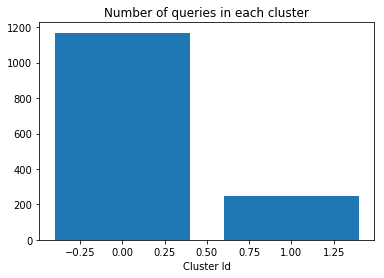

In [172]:
ms_clustering = mean_shift(data)

In [173]:
get_ari(ms_clustering, labels)

ARI index: 0.07493886532438242


## Agglomerative Clustering 

Hierarchical approach. Also good when we don't have a set # of clusters. Aggolmerative means each sample starts in its own cluster, and recursively merges with neighbors depending on a distance/linkage method. 

Types of linkages that we can experiment with (stolen from sklearn): 
- *Ward* minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- *Maximum* or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- *Average* linkage minimizes the average of the distances between all observations of pairs of clusters.
- *Single* linkage minimizes the distance between the closest observations of pairs of clusters.

In [174]:
from sklearn.cluster import AgglomerativeClustering

# FIX: CURRENT VERSION OF SKLEARN DOESNT ALLOW FOR NONE CLUSTERS 
# because distance_threshold isn't an attribute...???
clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage="ward").fit(data)


<BarContainer object of 19 artists>

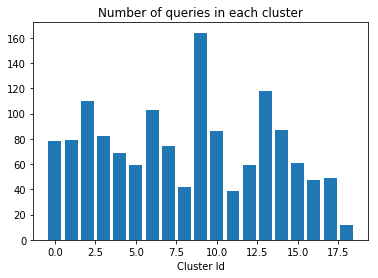

In [54]:
plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(clustering.labels_))

In [175]:
ari = metrics.adjusted_rand_score(labels, clustering.labels_) 
print("ARI index: " + str(ari))

ARI index: 0.30110115899309287


It looks like mean shift clustering gave us the best results for clustering by questionId. The accuracy of that method is easier to track becuase we had the labels (questionIDs). For the next section, results will be based on qualitative results--i.e., how closely do the queries within each cluster resemble eachother? 

## Clustering by questionID

In [179]:
q_dic

{4388082: 45,
 4388083: 1,
 4017605: 17,
 3902467: 33,
 3902466: 37,
 3893280: 186,
 3893287: 149,
 4014115: 4,
 4014112: 25,
 3893281: 188,
 3893288: 157,
 4014114: 8,
 4017607: 18,
 3689952: 41,
 3902464: 48,
 3902462: 58,
 3902465: 36,
 3893282: 199,
 3893285: 168}

In [193]:
def get_num_clusters(clusters):
    counter={}
    for i in clusters:
        if i in counter: 
            counter[i]+=1
        else:
            counter[i] = 1
    return counter

In [182]:
# given a variantID, get all queries and embeddings
# for that ID 

def get_question_queries(variant):
    variant_qids=[]
    for q in queries:
        if queries[q][0] == variant:
            variant_qids.append(q)
            
    subset_embs={}
    for e in emb:
        if e in variant_qids:
            subset_embs[e]=emb[e]
            
    data, qids=get_clustering_input(subset_embs)
    
    return data, qids

In [183]:
# start with just one question 
variant=3893285
data,qids=get_question_queries(variant)

In [185]:
NUM_CLUSTERS=6
kmeans_clustering=kmeans(data, 6)

Distribution of clusters: 
{2: 52, 5: 28, 1: 16, 4: 37, 0: 30, 3: 5}


In [ ]:
ms_clustering=me(data, 6)

In [192]:
for idx, i in enumerate(kmeans_clustering):
    if i==3:
        print(queries[qids[idx]])
        print("\n")

[3893285, 'SELECT A.ProductName, SUM(CASE WHEN (A.YearReleased > B.YearReleased AND A.BrandName = B.BrandName)  THEN 1 ELSE 0 END)\nFROM Products A, Products B\nGROUP BY A.ProductName']


[3893285, 'Select A.ProductName, Count(B.YearReleased)\nFrom Products A left outer join Products B on A.YearReleased > B.YearReleased and A.BrandName = B.BrandName\nGroup by A.ProductName\n\n-- SELECT A.FirstName, A.LastName, A.NetID, SUM(B.Credits)\n-- FROM Students A, Enrollments B\n-- WHERE A.NetId = B.NetId\n-- Group BY B.NetId \n-- Having SUM(B.Credits)>12\n-- ORDER BY SUM(B.Credits) DESC, A.FirstName\n']


[3893285, 'SELECT Prod.ProductName, SUM(Prod.YearReleased > Prod1.YearReleased) FROM Products Prod\nJOIN Products Prod1 ON Prod.BrandName = Prod1.BrandName\nGROUP BY Prod.ProductName']


[3893285, 'select p1.ProductName, sum(if(p2.YearReleased < p1.YearReleased, 1, 0))\nfrom Products p1 inner join Products p2\non p1.BrandName = p2.BrandName\ngroup by p1.ProductName\norder by p1.ProductName\n']

In [202]:
nc=get_num_clusters(kmeans_clustering)

with open('kmeans_output_3893285.tsv', 'w') as outf:
    for i in sorted(nc):
        outf.write("\n\n\n######################################################################\n")
        outf.write("# Cluster: " + str(i) + "         \n")
        outf.write("######################################################################\n\n")
        for idx, c in enumerate(kmeans_clustering):
            if c==i:
                outf.write(str(queries[qids[idx]][0]) + "\n")
                outf.write(queries[qids[idx]][1])
                outf.write("\n\n")

In [ ]:
## old code for spectral clustering and ari index if we have labels 

sp = SpectralClustering(n_clusters=NUM_CLUSTERS,
        assign_labels="discretize",
        random_state=0)
sp.fit(data)


ari = metrics.adjusted_rand_score(labels, clusters) 
print("ARI index: " + str(ari))
print("\n\n")

# labels = zip(readme_docs, clusters)
# np.save("pickles/"+pickle_label+"_labels", labels, allow_pickle=True, fix_imports=True)